In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("processed_data.csv")

# Show first few rows
df.head()


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,25,Male,Student,Bangladesh,0.0,"Facebook, YouTube, LinkedIn",Yes,6,2.555556,Single,2,9.333333
1,2,25,Male,Student,Bangladesh,0.5,Facebook,No,6,6.444444,Single,1,4.000000
2,3,25,Male,Student,Bangladesh,0.5,"Facebook, YouTube, Snapchat",Yes,6,6.222222,Single,1,6.333333
3,4,25,Male,Student,Bangladesh,8.0,"Facebook, YouTube, LinkedIn",Yes,6,5.666667,Single,4,9.333333
4,5,25,Male,Student,Bangladesh,2.0,"Facebook, YouTube",Yes,8,4.555556,Single,2,7.083333


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('processed_data.csv')

# Data preprocessing: Label Encoding for categorical variables
label_cols = ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Creating Binary and Multi-class targets
df['Mental_Health_Binary'] = df['Mental_Health_Score'].apply(lambda x: 1 if x <= 5 else 0)

def multi_class_label(score):
    if score <= 4:
        return 0
    elif score <= 7:
        return 1
    else:
        return 2

df['Mental_Health_Multiclass'] = df['Mental_Health_Score'].apply(multi_class_label)

# Feature Scaling for continuous variables
scaler = StandardScaler()
df[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Addicted_Score']] = scaler.fit_transform(df[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Addicted_Score']])

# Splitting data into features and targets for Binary and Multiclass
X = df.drop(columns=['Mental_Health_Score', 'Mental_Health_Binary', 'Mental_Health_Multiclass'])
y_binary = df['Mental_Health_Binary']
y_multi = df['Mental_Health_Multiclass']

# Initialize Stratified K-Fold Cross-Validation (K=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Binary Classification models and their hyperparameter grids for GridSearchCV
binary_models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),  # No GridSearchCV for Naive Bayes
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=300),
    "LSTM": Sequential([
        LSTM(64, input_shape=(X.shape[1], 1), return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
}

# Hyperparameter grids for tuning
binary_param_grid = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear'],
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    },
    'MLP': {
        'hidden_layer_sizes': [(64,), (64, 32)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
    }
}

# GridSearchCV for binary models (skip Naive Bayes)
binary_best_models = {}
for model_name, model in binary_models.items():
    print(f"Running GridSearchCV for {model_name}...")
    if model_name == "Naive Bayes":  # Skip GridSearch for Naive Bayes
        model.fit(X, y_binary)
        binary_best_models[model_name] = model
        continue
    if model_name == "LSTM":  # Skip GridSearch for LSTM as it is a deep learning model with a different structure
        continue
    grid_search = GridSearchCV(model, binary_param_grid[model_name], cv=kf, n_jobs=-1, verbose=1)
    grid_search.fit(X, y_binary)  # For binary classification
    binary_best_models[model_name] = grid_search.best_estimator_

# Function to evaluate models using Stratified K-Fold
def evaluate_models(models, X, y):
    results = {}

    for model_name, model in models.items():
        fold_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

        for train_index, val_index in kf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # For LSTM, reshape the data
            if model_name == "LSTM":
                X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
                X_val_lstm = np.reshape(X_val.values, (X_val.shape[0], 1, X_val.shape[1]))
            else:
                X_train_lstm = X_train
                X_val_lstm = X_val

            # Train the model
            if model_name == "LSTM":
                model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)  # LSTM needs epochs
            else:
                model.fit(X_train_lstm, y_train)  # No epochs needed for non-deep learning models

            # Make predictions
            y_pred = model.predict(X_val_lstm) > 0.5  # Convert output to binary (0 or 1) for binary classification
            y_pred = y_pred.astype("int32")

            # Evaluate performance
            fold_results['accuracy'].append(accuracy_score(y_val, y_pred))
            fold_results['precision'].append(precision_score(y_val, y_pred))
            fold_results['recall'].append(recall_score(y_val, y_pred))
            fold_results['f1_score'].append(f1_score(y_val, y_pred))

        # Store the average of each metric
        results[model_name] = {
            'accuracy': np.mean(fold_results['accuracy']),
            'precision': np.mean(fold_results['precision']),
            'recall': np.mean(fold_results['recall']),
            'f1_score': np.mean(fold_results['f1_score']),
        }

    return results

# Evaluate the binary models
binary_results = evaluate_models(binary_best_models, X, y_binary)

# Print results for binary classification
for model_name, metrics in binary_results.items():
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}\n")


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearchCV for MLP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Running GridSearchCV for LSTM...


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Metrics for Random Forest:
Accuracy: 0.8720
Precision: 0.9153
Recall: 0.9207
F1-Score: 0.9176

Metrics for Logistic Regression:
Accuracy: 0.8667
Precision: 0.9045
Recall: 0.9259
F1-Score: 0.9148

Metrics for Naive Bayes:
Accuracy: 0.8280
Precision: 0.9521
Recall: 0.8190
F1-Score: 0.8803

Metrics for SVM:
Accuracy: 0.8693
Precision: 0.9103
Recall: 0.9224
F1-Score: 0.9162

Metrics for MLP:
Accuracy: 0.8613
Precision: 0.9047
Recall: 0.9172
F1-Score: 0.9109



C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [4]:
# Convert evaluation results into a DataFrame formatted like the screenshot
result_table = pd.DataFrame([
    [model,
     round(metrics['f1_score'], 6),
     round(metrics['accuracy'], 6),
     round(metrics['recall'], 6),
     round(metrics['precision'], 6)]
    for model, metrics in binary_results.items()
], columns=["", "F1-Score", "Accuracy", "Recall", "Precision"])

# Optional: Sort by F1-Score descending (as in screenshot)
result_table = result_table.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# Display the table like in the image
print(result_table.to_string(index=False))


                     F1-Score  Accuracy   Recall  Precision
      Random Forest  0.917596  0.872000 0.920690   0.915338
                SVM  0.916150  0.869333 0.922414   0.910312
Logistic Regression  0.914844  0.866667 0.925862   0.904513
                MLP  0.910853  0.861333 0.917241   0.904729
        Naive Bayes  0.880337  0.828000 0.818966   0.952100


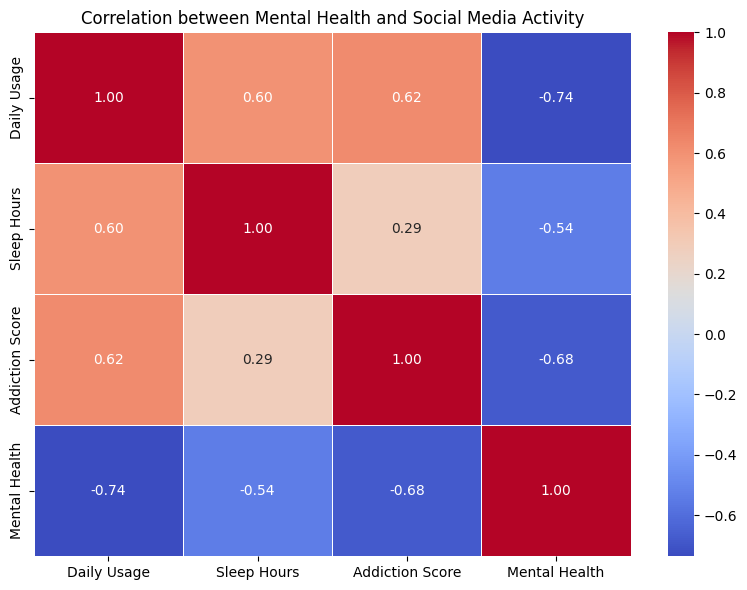

In [5]:
# Add back the Mental Health Score temporarily for correlation analysis
df_corr = df.copy()
df_corr['Mental_Health_Score'] = df['Mental_Health_Score']  # already present originally

# Optional: Rename for better visualization
df_corr.rename(columns={
    'Avg_Daily_Usage_Hours': 'Daily Usage',
    'Sleep_Hours_Per_Night': 'Sleep Hours',
    'Addicted_Score': 'Addiction Score',
    'Mental_Health_Score': 'Mental Health'
}, inplace=True)

# Select only relevant numeric columns
correlation_features = ['Daily Usage', 'Sleep Hours', 'Addiction Score', 'Mental Health']

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr[correlation_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation between Mental Health and Social Media Activity")
plt.tight_layout()
plt.show()


Confusion Matrix for Random Forest:


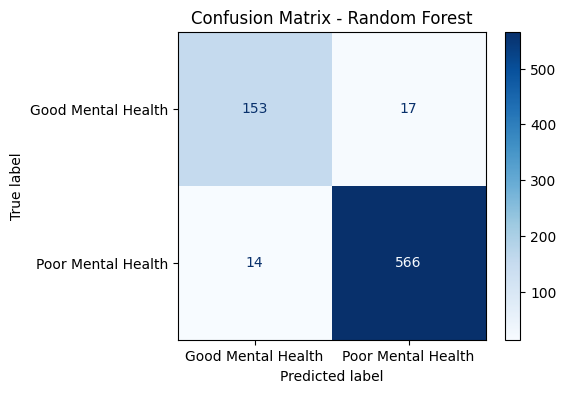

Confusion Matrix for Logistic Regression:


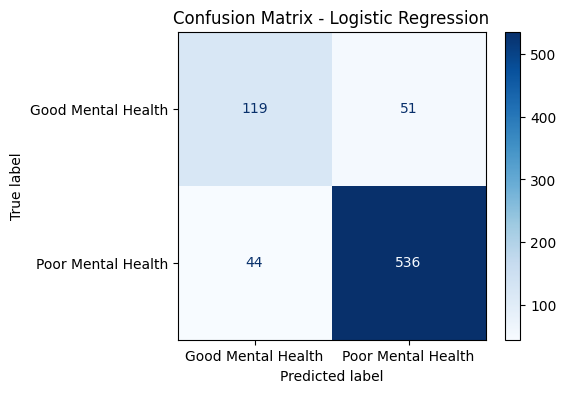

Confusion Matrix for Naive Bayes:


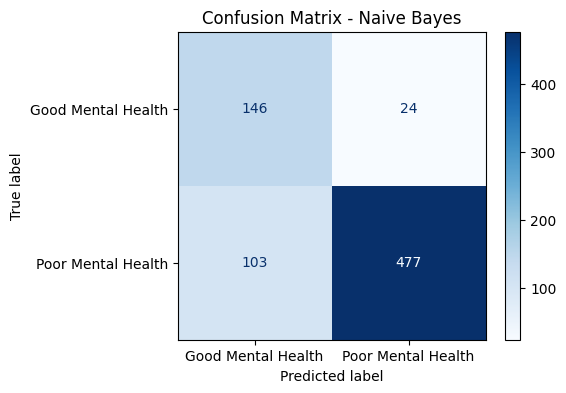

Confusion Matrix for SVM:


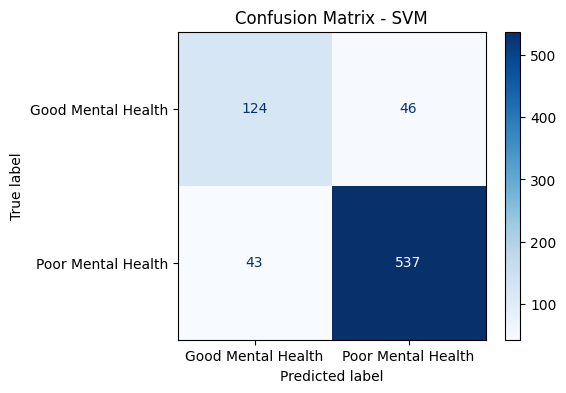

Confusion Matrix for MLP:


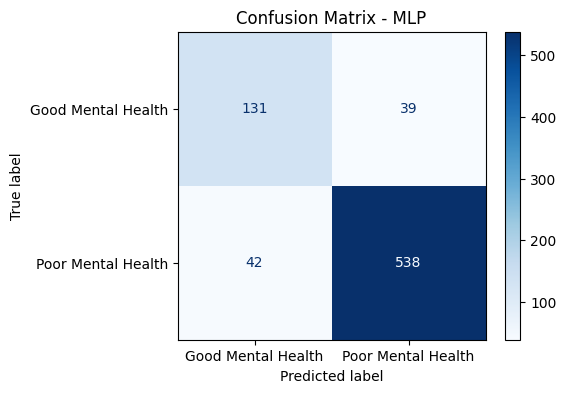

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for all models except LSTM
for model_name, model in binary_best_models.items():
    if model_name == "LSTM":
        continue  # Skip LSTM

    print(f"Confusion Matrix for {model_name}:")

    # Predict on full dataset
    y_pred = model.predict(X)

    # Create confusion matrix
    cm = confusion_matrix(y_binary, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good Mental Health', 'Poor Mental Health'])

    # Plot
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def multi_class_label(score):
    if score <= 4:
        return 0
    elif score <= 7:
        return 1
    else:
        return 2

df['Mental_Health_Multiclass'] = df['Mental_Health_Score'].apply(multi_class_label)

# Feature Scaling for continuous variables
scaler = StandardScaler()
df[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Addicted_Score']] = scaler.fit_transform(df[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Addicted_Score']])

# Splitting data into features and targets for Multiclass
X = df.drop(columns=['Mental_Health_Score', 'Mental_Health_Binary', 'Mental_Health_Multiclass'])
y_multi = df['Mental_Health_Multiclass']

# Initialize Stratified K-Fold Cross-Validation (K=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define models for Multiclass Classification
multi_models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CNN": Sequential([  # CNN for classification (Reshape data before fitting)
        Conv1D(32, 3, activation='relu', input_shape=(X.shape[1], 1)),
        MaxPooling1D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 output classes for multiclass classification
    ])
}


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Hyperparameter grids for tuning Multiclass models (excluding CNN)
multi_param_grid = {
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
    },
    'LightGBM': {
        'num_leaves': [31, 64],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200],
    },
    'XGBoost': {
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200],
    },
    'MLP': {
        'hidden_layer_sizes': [(64,), (128,)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
    }
}


In [11]:
# GridSearchCV for Multiclass models (excluding CNN)
multi_best_models = {}
for model_name, model in multi_models.items():
    if model_name == "CNN":
        continue  # Skip CNN for GridSearchCV

    print(f"Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(model, multi_param_grid[model_name], cv=kf, n_jobs=-1, verbose=1)
    grid_search.fit(X, y_multi)
    multi_best_models[model_name] = grid_search.best_estimator_


Running GridSearchCV for Decision Tree...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running GridSearchCV for KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Running GridSearchCV for LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 11
[LightGBM] [Info] Start training from score -0.450462
[LightGBM] [Info] Start training from score -1.110685
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Prepare data for CNN (reshape for 1D CNN)
X_cnn = np.reshape(X.values, (X.shape[0], X.shape[1], 1))

# One-hot encode target labels for multiclass
y_cnn = to_categorical(y_multi, num_classes=3)

# Define CNN architecture
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes for multiclass classification
])

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with K-Fold cross-validation
cnn_results = []
for train_index, val_index in kf.split(X, y_multi):
    X_train, X_val = X_cnn[train_index], X_cnn[val_index]
    y_train, y_val = y_cnn[train_index], y_cnn[val_index]

    # Train the CNN model
    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate on validation set
    score = cnn_model.evaluate(X_val, y_val, verbose=0)
    cnn_results.append(score[1])  # Accuracy score

# Print CNN results
print(f"CNN Accuracy: {np.mean(cnn_results):.4f}")


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Accuracy: 0.8293


In [13]:
# Function to evaluate models using Stratified K-Fold for Multiclass
def evaluate_multiclass_models(models, X, y):
    results = {}

    for model_name, model in models.items():
        fold_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

        for train_index, val_index in kf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            if model_name == "CNN":
                X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
                X_val_cnn = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))
            else:
                X_train_cnn = X_train
                X_val_cnn = X_val

            # Train the model
            if model_name == "CNN":
                model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
            else:
                model.fit(X_train_cnn, y_train)

            # Make predictions
            y_pred = model.predict(X_val_cnn)

            # If the model returns probabilities (e.g., CNN, MLP, LightGBM, XGBoost)
            if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
                y_pred = np.argmax(y_pred, axis=1)  # Get the predicted class index for probabilities
            else:
                y_pred = y_pred.astype(int)  # If already class labels, no need for argmax

            # Evaluate performance
            fold_results['accuracy'].append(accuracy_score(y_val, y_pred))
            fold_results['precision'].append(precision_score(y_val, y_pred, average='weighted'))
            fold_results['recall'].append(recall_score(y_val, y_pred, average='weighted'))
            fold_results['f1_score'].append(f1_score(y_val, y_pred, average='weighted'))

        # Store the average of each metric
        results[model_name] = {
            'accuracy': np.mean(fold_results['accuracy']),
            'precision': np.mean(fold_results['precision']),
            'recall': np.mean(fold_results['recall']),
            'f1_score': np.mean(fold_results['f1_score']),
        }

    return results

# Evaluate the Multiclass models
multi_results = evaluate_multiclass_models(multi_best_models, X, y_multi)

# Print results for Multiclass classification
for model_name, metrics in multi_results.items():
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}\n")


C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 11
[LightGBM] [Info] Start training from score -0.451509
[LightGBM] [Info] Start training from score -1.108663
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 11
[LightGBM] [Info] Start training from score -0.451509
[LightGBM] [Info] Start training from score -1.108663
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 11
[LightGBM] [Info] Start training from score -0.448895
[LightGBM] [Info] Start training from score -1.113726
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Metrics for Decision Tree:
Accuracy: 0.7893
Precision: 0.7919
Recall: 0.7893
F1-Score: 0.7894

Metrics for KNN:
Accuracy: 0.8067
Precision: 0.8022
Recall: 0.8067
F1-Score: 0.7977

Metrics for LightGBM:
Accuracy: 0.8467
Precision: 0.8226
Recall: 0.8467
F1-Score: 0.8333

Metrics for XGBoost:
Accuracy: 0.8467
Precision: 0.8271
Recall: 0.8467
F1-Score: 0.8346

Metrics for MLP:
Accuracy: 0.8400
Precision: 0.8268
Recall: 0.8400
F1-Score: 0.8309



C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dipra\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Convert evaluation results into a DataFrame formatted for multiclass models
result_table_multiclass = pd.DataFrame([
    [model,
     round(metrics['f1_score'], 6),
     round(metrics['accuracy'], 6),
     round(metrics['recall'], 6),
     round(metrics['precision'], 6)]
    for model, metrics in multi_results.items()
], columns=["Model", "F1-Score", "Accuracy", "Recall", "Precision"])

# Optional: Sort by F1-Score descending
result_table_multiclass = result_table_multiclass.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# Display the table
print(result_table_multiclass.to_string(index=False))


        Model  F1-Score  Accuracy   Recall  Precision
      XGBoost  0.834616  0.846667 0.846667   0.827147
     LightGBM  0.833284  0.846667 0.846667   0.822596
          MLP  0.830932  0.840000 0.840000   0.826773
          KNN  0.797684  0.806667 0.806667   0.802174
Decision Tree  0.789360  0.789333 0.789333   0.791859


Confusion Matrix for Decision Tree:


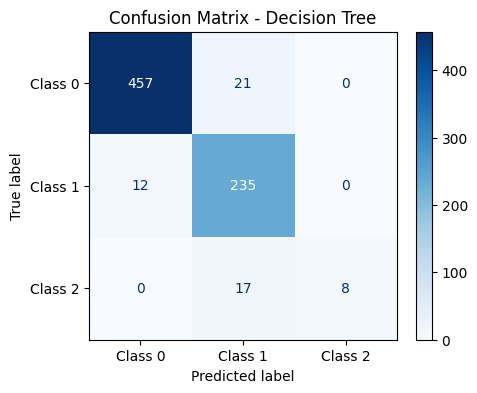

Confusion Matrix for KNN:


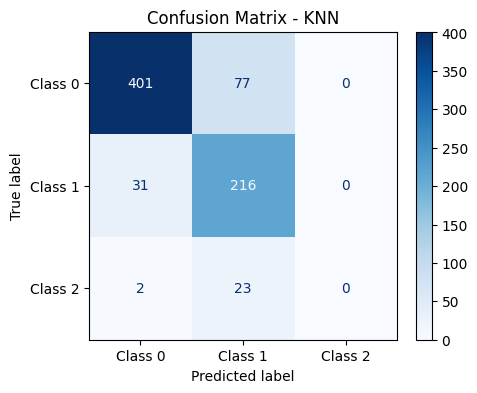

Confusion Matrix for LightGBM:


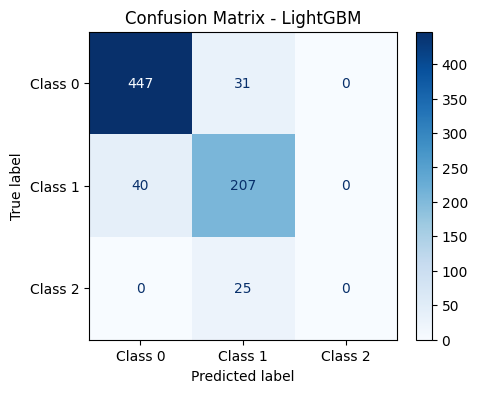

Confusion Matrix for XGBoost:


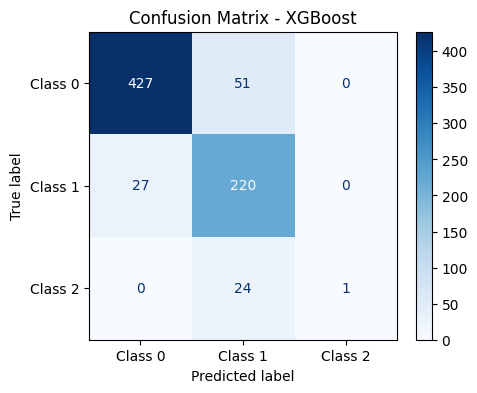

Confusion Matrix for MLP:


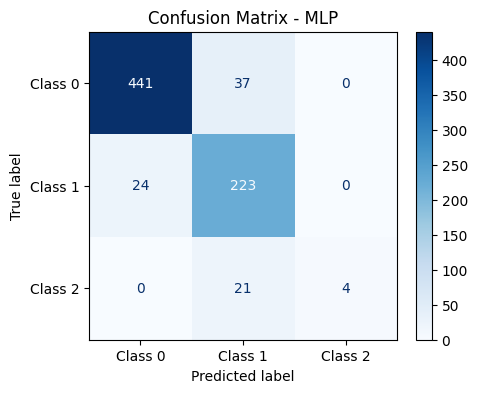

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Confusion Matrix for all Multiclass models
for model_name, model in multi_best_models.items():
    if model_name == "CNN":
        continue  # Skip CNN (it's handled separately with manual training)

    print(f"Confusion Matrix for {model_name}:")

    # Predict on full dataset
    y_pred = model.predict(X)

    # If the model returns probabilities (e.g., CNN, MLP, XGBoost)
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    else:
        y_pred = y_pred.astype(int)  # If already class labels, convert to integers

    # Create confusion matrix
    cm = confusion_matrix(y_multi, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])  # Adjust labels as needed

    # Plot
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.show()
